In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Constants
relevance_score_weight_clicked = 1
relevance_score_weight_booked = 5

In [9]:
df = pd.read_csv("training_set_cleaned.csv")
df_test = pd.read_csv("test_set_cleaned.csv")

In [10]:
# Is the trip international
df['is_international_trip'] = df['prop_country_id'] != df['visitor_location_country_id']
df_test['is_international_trip'] = df_test['prop_country_id'] != df_test['visitor_location_country_id']

# Ratio of property star rating over property review score
df['star_review_ratio'] = df['prop_starrating']/df['prop_review_score']
df_test['star_review_ratio'] = df_test['prop_starrating']/df_test['prop_review_score']


In [11]:
# Discounted price compared to historical log price
df['discount_score'] = df['prop_log_historical_price'].apply(np.exp) - df['price_usd']
df_test['discount_score'] = df_test['prop_log_historical_price'].apply(np.exp) - df_test['price_usd']


# How popular is the property overall (historically booked or clicked)
prop_click_rate = df.groupby('prop_id')['click_bool'].mean().rename("prop_click_rate")
prop_book_rate = df.groupby('prop_id')['booking_bool'].mean().rename("prop_book_rate")
df = df.merge(prop_click_rate, on='prop_id', how='left')
df = df.merge(prop_book_rate, on='prop_id', how='left')
df_test = df_test.merge(prop_click_rate, on='prop_id', how='left')
df_test = df_test.merge(prop_book_rate, on='prop_id', how='left')

In [12]:

# Average price, star rating, review in a search
avg_price_per_search = df.groupby('srch_id')['price_usd'].mean().rename("average_price_per_search")
avg_star_per_search = df.groupby('srch_id')['prop_starrating'].mean().rename("average_star_per_search")
avg_review_per_search = df.groupby('srch_id')['prop_review_score'].mean().rename("average_review_per_search")
df = df.merge(avg_price_per_search, on='srch_id', how='left')
df = df.merge(avg_star_per_search, on='srch_id', how='left')
df = df.merge(avg_review_per_search, on='srch_id', how='left')

avg_price_per_search_test = df_test.groupby('srch_id')['price_usd'].mean().rename("average_price_per_search")
avg_star_per_search_test = df_test.groupby('srch_id')['prop_starrating'].mean().rename("average_star_per_search")
avg_review_per_search_test = df_test.groupby('srch_id')['prop_review_score'].mean().rename("average_review_per_search")
df_test = df_test.merge(avg_price_per_search_test, on='srch_id', how='left')
df_test = df_test.merge(avg_star_per_search_test, on='srch_id', how='left')
df_test = df_test.merge(avg_review_per_search_test, on='srch_id', how='left')

In [13]:
# Difference between property price and average price per search
df['price_dif2'] = df['price_usd'] - df['average_price_per_search']
df_test['price_dif2'] = df_test['price_usd'] - df_test['average_price_per_search']

# Difference between property star rating and average star rating per search
df['star_dfi2'] = df['prop_starrating'] - df['average_star_per_search']
df_test['star_dfi2'] = df_test['prop_starrating'] - df_test['average_star_per_search']

# Difference between property review score and average review score per search
df['review_dif'] = df['prop_review_score'] - df['average_review_per_search']
df_test['review_dif'] = df_test['prop_review_score'] - df_test['average_review_per_search']

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

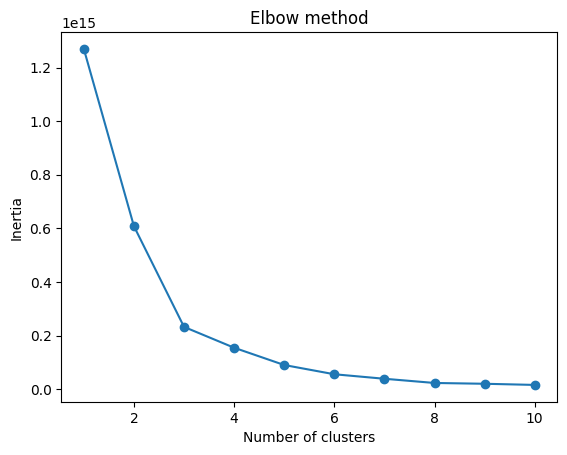

In [ ]:
# Select relevant hotel features
hotel_features = df[['prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_brand_bool', 'price_usd', 'prop_log_historical_price', 'promotion_flag']].copy()
hotel_features_test = df_test[['prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_brand_bool', 'price_usd', 'prop_log_historical_price', 'promotion_flag']].copy()

# Apply elbow method
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(hotel_features)
    inertias.append(kmeans.inertia_)

# Visualise results
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=3)
df['hotel_cluster_id'] = kmeans.fit_predict(hotel_features)
kmeans = KMeans(n_clusters=3)
df_test['hotel_cluster_id'] = kmeans.fit_predict(hotel_features_test)

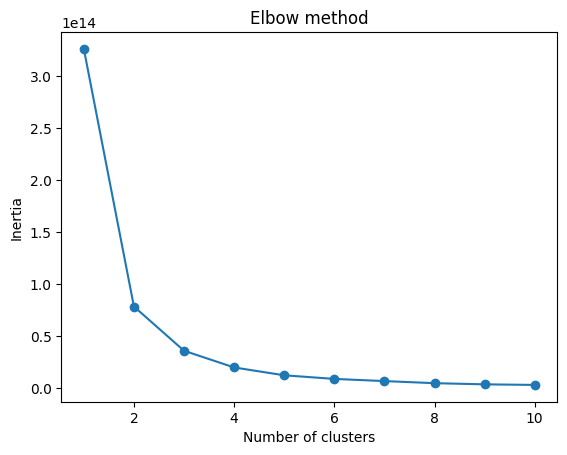

In [18]:
# Select relevant search features
search_features = df[['srch_length_of_stay', 'srch_booking_window', 
                      'srch_adults_count', 'srch_children_count', 
                      'srch_room_count', 'srch_destination_id', 
                      'srch_saturday_night_bool']].copy()

# Select relevant search features
search_features_test = df_test[['srch_length_of_stay', 'srch_booking_window', 
                      'srch_adults_count', 'srch_children_count', 
                      'srch_room_count', 'srch_destination_id', 
                      'srch_saturday_night_bool']].copy()


# Apply elbow method
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(search_features)
    inertias.append(kmeans.inertia_)

# Visualise results
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [19]:
kmeans = KMeans(n_clusters=3)
df['search_cluster_id'] = kmeans.fit_predict(search_features)
kmeans = KMeans(n_clusters=3)
df_test['search_cluster_id'] = kmeans.fit_predict(search_features_test)

In [20]:
df['relevance_score'] = relevance_score_weight_clicked * df['click_bool'] + relevance_score_weight_booked * df['booking_bool']

In [21]:
# Save to a new file
df.to_csv("training_set_final.csv", index=False)
df_test.to_csv("test_set_final.csv", index=False)